# Lab | API wrappers - Create your collection of songs & audio features
# Lab | Unsupervised learning intro.

Jorge Castro DAPT NOV 2021

In [81]:
from bs4 import BeautifulSoup
import requests
import math
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import getpass

In [119]:
pwd


'C:\\Users\\jcast\\lab-web-scraping-single-page'

In [3]:
r = requests.get('https://www.billboard.com/charts/hot-100/')

In [4]:
r.status_code

200

In [5]:
html = r.content

In [6]:
#html

In [7]:
soup = BeautifulSoup(html, 'html.parser')

In [8]:
#soup

In [9]:
html_songs = soup.find_all('h3', attrs={'id': 'title-of-a-story'})

In [10]:
#html_songs

In [11]:
html_top1 = soup.find_all('span', attrs={'class': 'c-label a-no-trucate a-font-primary-s \
lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 \
lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet'})


In [12]:
html_top1

[<span class="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet">
 	
 	Harry Styles
 </span>]

In [13]:
html_artists = soup.find_all('span', attrs={'class': 'c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max \
u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 \
u-max-width-230@tablet-only'})

In [14]:
#html_artists

In [15]:
# Looking with "Inspect" in the Billboard chart, a parent class "li" contains the info of both song titles and artists:
# Because the fonts are different, the first song has one class and all the rest of the songs have another class. So 
# we have to put the 2 list toguether. 

In [16]:
html_first = soup.find_all('li', attrs={'class': 'o-chart-results-list__item // lrv-u-flex-grow-1 lrv-u-flex \
lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-border-b-1 u-border-b-0@mobile-max \
lrv-u-border-color-grey-light lrv-u-padding-l-1@mobile-max'})

In [17]:
#html_first

In [18]:

html_rest = soup.find_all('li', attrs={'class': 'o-chart-results-list__item // lrv-u-flex-grow-1 lrv-u-flex \
lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-border-b-1 u-border-b-0@mobile-max lrv-u-border-color-grey-light \
lrv-u-padding-l-050 lrv-u-padding-l-1@mobile-max'})

In [19]:
#html_rest

In [20]:
# I can now join the 2 lists

In [21]:
html_all = html_first + html_rest

In [22]:
#html_all

## Data Cleaning

In [23]:
# Creating a DataFrame: here we create two arrays, we loop through the content in html_all
# then we push the data we need into the two arrays. 

song = []
artist = []

for entry in html_all:
    song.append(entry.find("h3").get_text().replace("\n", "").replace('\t', ''))
    artist.append(entry.find("span").get_text().replace("\n", "").replace('\t', ''))
    
# Here we ensamble the DataFrame 
top100 = pd.DataFrame()
top100['song'] = song
top100['artist'] = artist
top100
    

,song,artist
0,As It Was,Harry Styles
1,First Class,Jack Harlow
2,Heat Waves,Glass Animals
3,Big Energy,Latto
4,Enemy,Imagine Dragons X JID
...,...,...
95,P Power,Gunna Featuring Drake
96,Money So Big,Yeat
97,Blick Blick!,Coi Leray & Nicki Minaj
98,Fall In Love,Bailey Zimmerman


In [24]:
client_id = getpass.getpass(prompt='input client_id') 
client_secret = getpass.getpass(prompt='input client_secret')

input client_id ································
input client_secret ································


In [25]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

In [26]:
#Get many songs from Spotify

In [27]:
user = 'spotify'

playlists = sp.user_playlists(user)
playlist_uri = []
playlist_names = []

while playlists:
    for playlist in playlists['items']:
        playlist_uri.append(playlist['uri'])
        playlist_names.append(playlist['name'])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

In [28]:
def get_tracks_from_playlist(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [29]:
def get_all_tracks(uri):

    s_id = []
    s_name = []
    s_artists = []
    
    results = get_tracks_from_playlist("",uri)
    c = 0
    for i in results:
        if i['track'] != None:
            s_id.append("missing value" if i['track']['id'] == None else i['track']['id'])
            s_name.append(i['track']['name'])
            s_artists.append([j['name'] for j in i['track']['artists']])

    return {'song_id':s_id, 'song_name':s_name, 'artists':s_artists}

In [30]:
songs = {'song_id':[], 'song_name':[], 'artists':[]}

for i in tqdm(playlist_uri):
    d = get_all_tracks(i)
    [songs['song_id'].append(i) for i in d['song_id']]
    [songs['song_name'].append(i) for i in d['song_name']]
    [songs['artists'].append(i) for i in d['artists']]

  0%|          | 0/1196 [00:00<?, ?it/s]

In [31]:
df_songs = pd.DataFrame(songs)
df_songs

,song_id,song_name,artists
0,2KdKh9vHbKW0tZLqtpxxI0,Honest (feat. Don Toliver),"[Justin Bieber, Don Toliver]"
1,1rDQ4oMwGJI7B4tovsBOxc,First Class,[Jack Harlow]
2,4LRPiXqCikLlN15c3yImP7,As It Was,[Harry Styles]
3,0QBzMgT7NIeoCYy3sJCof1,Bam Bam (feat. Ed Sheeran),"[Camila Cabello, Ed Sheeran]"
4,3USxtqRwSYz57Ewm6wWRMp,Heat Waves,[Glass Animals]
...,...,...,...
94315,5kqIPrATaCc2LqxVWzQGbk,7 Years,[Lukas Graham]
94316,3FCto7hnn1shUyZL42YgfO,Piano Man,[Billy Joel]
94317,3XVBdLihbNbxUwZosxcGuJ,If I Ain't Got You,[Alicia Keys]
94318,6QPKYGnAW9QozVz2dSWqRg,Someone Like You,[Adele]


In [32]:
df_songs = df_songs.drop_duplicates(subset='song_id').reset_index(drop=True)
df_songs

,song_id,song_name,artists
0,2KdKh9vHbKW0tZLqtpxxI0,Honest (feat. Don Toliver),"[Justin Bieber, Don Toliver]"
1,1rDQ4oMwGJI7B4tovsBOxc,First Class,[Jack Harlow]
2,4LRPiXqCikLlN15c3yImP7,As It Was,[Harry Styles]
3,0QBzMgT7NIeoCYy3sJCof1,Bam Bam (feat. Ed Sheeran),"[Camila Cabello, Ed Sheeran]"
4,3USxtqRwSYz57Ewm6wWRMp,Heat Waves,[Glass Animals]
...,...,...,...
71973,3Zuf70897YkrVRAsrBMMSF,"You're The One That I Want - From ""Grease"" Ori...","[John Travolta, Olivia Newton-John]"
71974,1MDoll6jK4rrk2BcFRP5i7,Hello,[Adele]
71975,0ygTmpa6uSotkBkTiwcMZ4,Warwick Avenue,[Duffy]
71976,3NNqqioprPCnYcVtDn3wvS,Catch & Release (Deepend remix),"[Matt Simons, Deepend]"


In [33]:
features_list = []
for i in tqdm(range(math.ceil(df_songs.shape[0]/100))):
    features_list.append(sp.audio_features(df_songs['song_id'].to_list()[i*100:(i+1)*100]))

  0%|          | 0/720 [00:00<?, ?it/s]

In [34]:
features = []
[[(features.append(j) if j != None else None) for j in i] for i in features_list]
pass

In [35]:
dic = defaultdict(list)
{dic[key].append(f[key]) for f in features for key in f}  
df_features = pd.DataFrame(dict(dic))

In [36]:
df_songs.shape

(71978, 3)

In [37]:
df_features.shape

(71693, 18)

In [38]:
df_features = df_features[df_features['speechiness']<0.8]

In [39]:
df_all = df_songs.merge(df_features.rename({'id':'song_id'}, axis=1), on='song_id', how='right')
df_all.columns

Index(['song_id', 'song_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [40]:
df_all = df_all.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)

In [41]:
df_all.head()

,song_id,song_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2KdKh9vHbKW0tZLqtpxxI0,Honest (feat. Don Toliver),"[Justin Bieber, Don Toliver]",0.810,0.655,8,-6.779,0,0.0698,0.1270,0.000082,0.1050,0.809,150.002,193322,4
1,1rDQ4oMwGJI7B4tovsBOxc,First Class,[Jack Harlow],0.905,0.563,8,-6.135,1,0.1020,0.0254,0.000010,0.1130,0.324,106.998,173948,4
2,4LRPiXqCikLlN15c3yImP7,As It Was,[Harry Styles],0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,173.930,167303,4
3,0QBzMgT7NIeoCYy3sJCof1,Bam Bam (feat. Ed Sheeran),"[Camila Cabello, Ed Sheeran]",0.756,0.697,8,-6.377,1,0.0401,0.1820,0.000000,0.3330,0.956,94.996,206071,4
4,3USxtqRwSYz57Ewm6wWRMp,Heat Waves,[Glass Animals],0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,238805,4


In [42]:
# Feature selection

In [43]:
X_cont = df_all[['danceability','energy','loudness','speechiness',
                       'acousticness','instrumentalness','liveness','valence',
                       'tempo','duration_ms']]

In [44]:
X_disc = df_all[['key','mode','time_signature']]

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont_st = scaler.fit_transform(X_cont)
X_cont_st = pd.DataFrame(X_cont_st, columns=X_cont.columns)

In [46]:
X_disc = X_disc.astype('object')
X_disc

,key,mode,time_signature
0,8,0,4
1,8,1,4
2,6,0,4
3,8,1,4
4,11,1,4
...,...,...,...
71044,0,1,4
71045,5,0,4
71046,0,0,4
71047,1,0,4


In [47]:
X_prep = pd.concat([X_cont_st, X_disc], axis=1)
X_prep

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
0,1.444551,0.398530,0.535885,-0.072987,-0.715863,-0.634049,-0.496986,1.448900,1.047256,-0.308862,8,0,4
1,1.946305,0.079174,0.623124,0.311382,-0.989200,-0.634246,-0.445362,-0.401288,-0.350819,-0.481005,8,1,4
2,-0.087119,0.662347,0.731088,-0.241298,-0.137443,-0.631510,0.832350,0.888121,1.825163,-0.540047,6,0,4
3,1.159344,0.544324,0.590342,-0.427514,-0.567895,-0.634272,0.974318,2.009678,-0.741008,-0.195584,8,1,4
4,1.185752,-0.052735,0.519494,0.220661,0.126209,-0.634254,-0.580231,0.388380,-1.200250,0.095266,11,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71044,1.132936,0.738715,0.343663,0.209918,-0.446831,-0.632128,0.174135,1.315381,-0.351534,-0.529705,0,1,4
71045,-0.345919,-0.379034,0.623937,-0.497942,-0.172418,-0.634272,-0.623467,-0.534807,1.306623,0.599032,5,0,4
71046,-0.229723,0.172898,0.666608,-0.438257,-0.145514,-0.634272,-0.393737,0.277750,1.694407,-0.015071,0,0,4
71047,1.581873,-0.142988,0.115542,-0.334406,0.319912,-0.631562,-0.458268,-1.221474,-0.415385,-0.283299,1,0,4


In [48]:
# Subset of X just for practical purposes (faster processing)

In [49]:
# With 1000 samples we get 7 clusters
X_prep = X_prep.sample(50000)

In [50]:
# Cluster

In [51]:
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

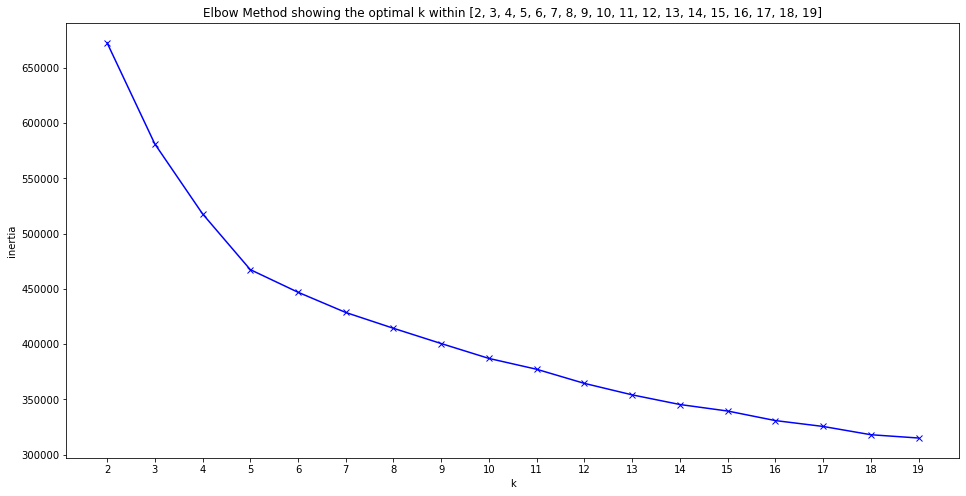

In [52]:
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(X_prep)
    inertias.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Silhouette Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

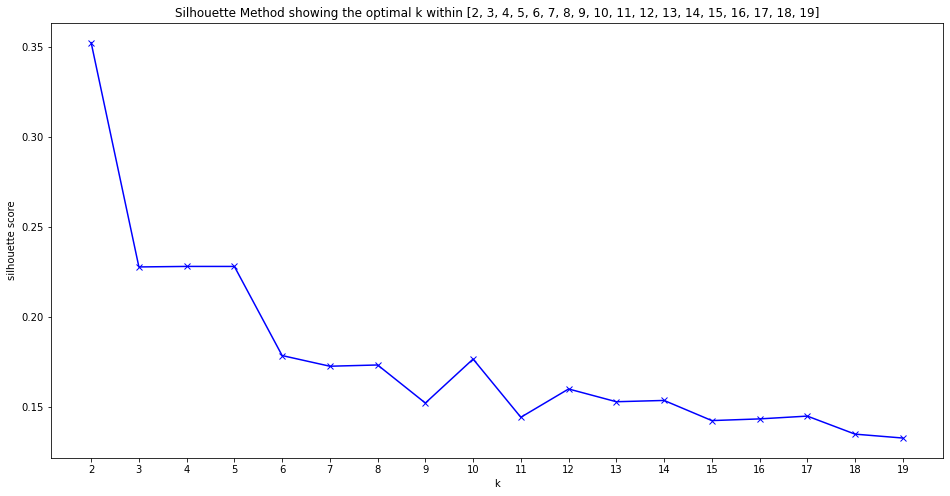

In [53]:
from sklearn.metrics import silhouette_score

import numpy as np
K = range(2,20)
silhouettes = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    silhouettes.append(silhouette_score(X_prep, kmeans.predict(X_prep) )
                   )
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette Method showing the optimal k within {list(K)}')

In [99]:
#I decide for 6 clusters


In [106]:
cols = X_prep.columns

In [107]:
kmeans = KMeans(n_clusters=6,
               random_state=1234)
kmeans.fit(X_prep)

clusters = kmeans.predict(X_prep)

In [108]:
clusters.shape

(50000,)

In [109]:
songs_clustered = X_prep.copy()
songs_clustered['cluster_id'] = clusters

In [110]:
songs_clustered

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature,cluster_id
51741,-2.083572,-1.864182,-3.580714,-0.435870,1.584365,1.433245,-0.438909,-1.179511,-1.558188,-0.573269,2,1,5,2
14227,0.124146,0.822025,0.773624,-0.336793,-0.789847,-0.633752,0.096698,1.452714,1.305876,-0.499992,7,1,4,4
17330,-0.092401,-1.606475,-1.741797,-0.155352,1.463300,1.788770,-0.484080,-0.290658,0.567501,-0.771979,7,0,3,5
67195,-0.219160,-0.965678,-0.484561,-0.413189,1.148532,1.857141,-0.516346,-0.054139,1.693074,0.090601,11,1,3,1
62281,0.113582,-0.125631,-0.549042,-0.515847,-0.632463,1.791505,-0.541513,-1.362241,-0.773746,0.276027,0,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32059,0.541394,-0.476230,-0.225690,-0.489586,0.467880,-0.634272,3.149009,-0.401288,0.480210,0.244493,7,1,4,4
41282,-0.620563,1.547520,1.106999,1.170840,-1.052692,-0.634272,1.361503,0.296824,-0.740553,0.078979,8,1,4,4
65380,0.689279,0.745657,0.472624,-0.082537,-0.797649,-0.634082,-0.837064,1.731196,-0.268340,0.516560,9,1,4,1
21162,-0.520212,-0.899724,-0.502984,-0.488392,0.710009,-0.633438,-0.471174,-0.199102,0.637495,-0.040661,9,1,3,1


In [111]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cols)
cluster_centers_df['cluster_id'] = range(0,6)

In [112]:
# we can only plot 2 dimensions,
# so we take 'danceability', 'loudness'
# we also need the 'cluster_id' to color the dots with
clusters_sub_df = cluster_centers_df[['danceability', 'loudness', 'cluster_id']]
songs_sub_df = songs_clustered[['danceability', 'loudness', 'cluster_id']]

# Is a song in the Top 100 list?

In [114]:
def is_hot(song):
    s = top100['song'].str.contains(song, na=False, case=False)
    if s.sum() > 0:
        return True
    else:
        return False

In [115]:
is_hot('as it was')

True

# Ask for user input and recommend song

In [116]:
def recommend():
    print("""
    Enter your song's name. Example:
    >>> As it Was
    """)
    user_input = input()
    
    if is_hot(user_input):
        
        s = top100[top100['song'].str.contains(user_input, na=False, case=False)].sample()
        
        print('Match found!')
        print('* ' + '"' + s.iloc[0]['song'] + '"' + ' by ' + s.iloc[0]['artist'])
        s = top100.sample()
        print("""Your song is hot!\nHere's another one for you to check out:""")
        print('* ' + '"'+s.iloc[0]['song']+'"' + ' by ' + s.iloc[0]['artist'])
    else:
        
        result = sp.search(q=user_input, type='track', limit=1)
        song_audio_features = sp.audio_features(result['tracks']['items'][0]['id'])
        song_audio_features_df = pd.DataFrame(song_audio_features, columns=X_cont.columns)
        song_scaled = pd.DataFrame(scaler.transform(song_audio_features_df))
        song_disc = pd.DataFrame(song_audio_features, columns=['key','mode','time_signature'])
        song_audio_features = pd.concat([song_scaled,song_disc], axis=1)
        cl = kmeans.predict(song_audio_features)[0]
        recommendation = df_all.iloc[songs_clustered[songs_clustered.cluster_id==cl].sample().index]

        print("""Your song is not in the Top 100.\nHowever I found a similar match to your search:""")
        print("* " + str(result['tracks']['items'][0]['name']) +
              " by " +
              str(result['tracks']['items'][0]['artists'][0]['name']))
        print("Here's another one for you to check out:")
        print('* ' + str(recommendation.song_name.iloc[0]) +
              " by "
              + str([i for i in recommendation.artists.iloc[0]][0]))
    pass

# Execute

In [118]:
recommend()



    Enter your song's name. Example:
    >>> As it Was
    


 as it was


Match found!
* "As It Was" by Harry Styles
Your song is hot!
Here's another one for you to check out:
* "Woman" by Doja Cat
